# Initital code

In [1]:
import cv2
import numpy as np
from skimage import measure
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# Define functions

def identify_missing_regions(damaged_image):
    """
    Identify missing regions in the damaged image.

    Parameters:
    damaged_image (np.ndarray): The input damaged image (grayscale or color).

    Returns:
    labeled_image (np.ndarray): Labeled image.
    regions (list): List of region properties.
    binary_image (np.ndarray): Binary image with isolated damaged regions.
    """
    if len(damaged_image.shape) == 3 and damaged_image.shape[2] == 3:
        # Convert the image to grayscale if it is in color
        gray_image = cv2.cvtColor(damaged_image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = damaged_image
    
    # Use a fixed threshold to isolate the damaged region (black line)
    _, binary_image = cv2.threshold(gray_image, 10, 255, cv2.THRESH_BINARY_INV)
    
    # Perform morphological operations to clean up the binary image
    kernel = np.ones((3, 3), np.uint8)
    binary_image = cv2.erode(binary_image, kernel, iterations=1)
    binary_image = cv2.dilate(binary_image, kernel, iterations=2)
    
    # Label connected components
    labeled_image = measure.label(binary_image, connectivity=2)
    regions = measure.regionprops(labeled_image)
    
    return labeled_image, regions, binary_image

def sort_regions_by_area(regions):
    sorted_regions = sorted(regions, key=lambda region: region.area, reverse=True)
    return sorted_regions

def check_if_empty(L):
    if not L:
        print("List L is empty. The inpainting process is complete.")
        return True
    else:
        print("List L is not empty. Proceeding to the next steps.")
        return False

def select_and_dilate_smallest_region(L, original_image, dilation_size=10, dilation_iterations=2):
    if not L:
        raise ValueError("List L is empty. Cannot select and dilate the smallest region.")
    
    smallest_region = L[-1]
    
    mask = np.zeros(original_image.shape[:2], dtype=np.uint8)
    for coord in smallest_region.coords:
        mask[coord[0], coord[1]] = 255
    
    kernel = np.ones((dilation_size, dilation_size), np.uint8)
    dilated_mask = cv2.dilate(mask, kernel, iterations=dilation_iterations)
    
    return mask, dilated_mask

def crop_corresponding_area(dilated_mask, original_image):
    coords = cv2.findNonZero(dilated_mask)
    x, y, w, h = cv2.boundingRect(coords)
    cropped_area = original_image[y:y+h, x:x+w]
    return cropped_area, (x, y, w, h)

def compute_smoothing_parameter(cropped_image):
    I_x = cv2.Sobel(cropped_image, cv2.CV_64F, 1, 0, ksize=1)
    I_y = cv2.Sobel(cropped_image, cv2.CV_64F, 0, 1, ksize=1)
    G = np.sqrt(I_x**2 + I_y**2)
    rho = np.max(G)
    sigma = np.exp(1 - (rho / 255))
    return sigma, I_x, I_y

def dilated_mask_crop(cropped_image):
    if len(cropped_image.shape) == 3:
        _, dilated_mask = cv2.threshold(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY), 10, 255, cv2.THRESH_BINARY_INV)
    else:
        _, dilated_mask = cv2.threshold(cropped_image, 10, 255, cv2.THRESH_BINARY_INV)
    return dilated_mask

def create_training_data_from_cropped(cropped_image, dilated_mask, neighbor_radius=10):
    assert cropped_image.shape[:2] == dilated_mask.shape, "Dimensions of cropped image and mask must match."
    
    inpainting_region = dilated_mask.astype(bool)
    
    neighbor_mask = cv2.dilate(inpainting_region.astype(np.uint8), 
                               np.ones((2 * neighbor_radius + 1, 2 * neighbor_radius + 1), np.uint8), 
                               iterations=1) & ~inpainting_region

    coords = np.column_stack(np.where(neighbor_mask))
    
    if len(cropped_image.shape) == 3:  # Color image
        pixel_values = cropped_image[coords[:, 0], coords[:, 1], :]
    else:  # Grayscale image
        pixel_values = cropped_image[coords[:, 0], coords[:, 1]].reshape(-1, 1)
    
    return coords, pixel_values

class OptimizedGRNN:
    def __init__(self, sigma=None):
        self.sigma = sigma
        self.training_set = None
        self.target_values = None

    def fit(self, features, targets):
        self.training_set = features
        self.target_values = targets

    def predict(self, features, batch_size=1000):
        predictions = []
        for start in range(0, len(features), batch_size):
            end = start + batch_size
            batch_features = features[start:end]
            
            distance_matrix = cdist(batch_features, self.training_set, metric='sqeuclidean')
            kernel_matrix = np.exp(-distance_matrix / (2 * self.sigma ** 2))
            if len(self.target_values.shape) == 2 and self.target_values.shape[1] == 3:
                batch_predictions = np.dot(kernel_matrix, self.target_values) / kernel_matrix.sum(axis=1, keepdims=True)
            else:
                batch_predictions = np.dot(kernel_matrix, self.target_values) / kernel_matrix.sum(axis=1, keepdims=True)
            
            predictions.append(batch_predictions)
        
        return np.concatenate(predictions, axis=0)

def sharpen_image(image):
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    sharpened = cv2.filter2D(image, -1, kernel)
    return sharpened

# For smoothing and sharpening image

In [2]:
def anisotropic_diffusion(img, niter=10, kappa=50, gamma=0.1, voxelspacing=None, option=1):
    if img.ndim == 3:
        channels = cv2.split(img)
        diffused_channels = [anisotropic_diffusion_single_channel(ch, niter, kappa, gamma, voxelspacing, option) for ch in channels]
        return cv2.merge(diffused_channels)
    else:
        return anisotropic_diffusion_single_channel(img, niter, kappa, gamma, voxelspacing, option)

def anisotropic_diffusion_single_channel(img, niter=10, kappa=50, gamma=0.1, voxelspacing=None, option=1):
    img = img.astype('float32')

    if voxelspacing is not None:
        voxelspacing = np.asanyarray(voxelspacing, dtype='float32')
        gamma = gamma / (np.prod(voxelspacing) ** (1./3.))

    deltaS = np.zeros_like(img)
    deltaE = deltaS.copy()
    NS = deltaS.copy()
    EW = deltaS.copy()
    gS = np.ones_like(img)
    gE = gS.copy()

    for i in range(niter):
        deltaS[:-1, :] = np.diff(img, axis=0)
        deltaE[:, :-1] = np.diff(img, axis=1)

        if option == 1:
            gS = np.exp(-(deltaS / kappa) ** 2.)
            gE = np.exp(-(deltaE / kappa) ** 2.)
        elif option == 2:
            gS = 1. / (1. + (deltaS / kappa) ** 2.)
            gE = 1. / (1. + (deltaE / kappa) ** 2.)

        E = gE * deltaE
        S = gS * deltaS

        NS[:] = S
        EW[:] = E
        NS[1:, :] -= S[:-1, :]
        EW[:, 1:] -= E[:, :-1]

        img += gamma * (NS + EW)

    return img.astype(np.uint8)

def sharpen_image(image):
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    
    if image.ndim == 3:  # color image
        sharpened_channels = [cv2.filter2D(src=ch, ddepth=-1, kernel=kernel) for ch in cv2.split(image)]
        sharpened_image = cv2.merge(sharpened_channels)
    else:  # grayscale image
        sharpened_image = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)
    
    return sharpened_image

## to Calculate the area of damaged area

In [7]:
def percentile_area(L):
    area = 0
    for i, region in enumerate(L):
        area += region.area
    main_img = cv2.imread(r"C:\Users\VIET HOANG - VTS\Desktop\testdata\main_large.jpg", cv2.IMREAD_GRAYSCALE)
    total_area = main_img.shape[0]*main_img.shape[1]
    return (area/total_area)*100

# Fixing blockloss Errors

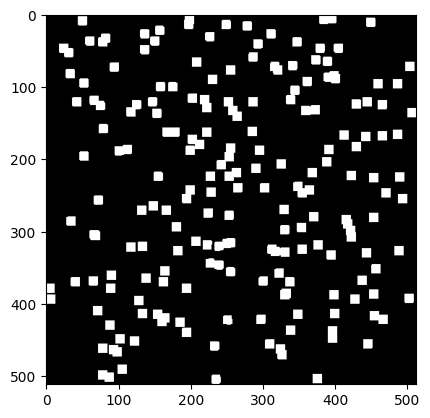

8.1692455858748
List L is not empty. Proceeding to the next steps.
159
(31, 31, 3)
(31, 31)
(797, 2)
158
(31, 22, 3)
(31, 22)
(450, 2)
157
(31, 20, 3)
(31, 20)
(464, 2)
156
(21, 31, 3)
(21, 31)
(489, 2)
155
(31, 31, 3)
(31, 31)
(692, 2)
154
(31, 31, 3)
(31, 31)
(758, 2)
153
(31, 31, 3)
(31, 31)
(721, 2)
152
(31, 31, 3)
(31, 31)
(794, 2)
151
(31, 31, 3)
(31, 31)
(796, 2)
150
(31, 31, 3)
(31, 31)
(796, 2)
149
(31, 31, 3)
(31, 31)
(732, 2)
148
(31, 31, 3)
(31, 31)
(777, 2)
147
(31, 31, 3)
(31, 31)
(677, 2)
146
(31, 31, 3)
(31, 31)
(755, 2)
145
(31, 31, 3)
(31, 31)
(796, 2)
144
(31, 31, 3)
(31, 31)
(796, 2)
143
(31, 31, 3)
(31, 31)
(795, 2)
142
(31, 31, 3)
(31, 31)
(795, 2)
141
(31, 31, 3)
(31, 31)
(741, 2)
140
(31, 31, 3)
(31, 31)
(788, 2)
139
(31, 31, 3)
(31, 31)
(794, 2)
138
(31, 31, 3)
(31, 31)
(715, 2)
137
(31, 31, 3)
(31, 31)
(776, 2)
136
(31, 31, 3)
(31, 31)
(795, 2)
135
(31, 31, 3)
(31, 31)
(752, 2)
134
(31, 31, 3)
(31, 31)
(771, 2)
133
(31, 31, 3)
(31, 31)
(795, 2)
132
(31, 31, 3)

In [9]:
# Main inpainting loop
damaged_image_multiple_rectangles = cv2.imread(r"C:\Users\VIET HOANG - VTS\Desktop\testoutput\square_errors_color.jpg")
labeled_image, regions, binary_image = identify_missing_regions(damaged_image_multiple_rectangles)
plt.imshow(binary_image, cmap='gray')
plt.show()
# Sort regions by area in descending order and store them in a list tagged as L
L = sort_regions_by_area(regions)
print(percentile_area(L))
if not check_if_empty(L):
    # Select and dilate the smallest region
    while L:
        print(len(L))
        mask, dilated_mask = select_and_dilate_smallest_region(L, damaged_image_multiple_rectangles)
        # Turn white noise areas into black
        damaged_image_multiple_rectangles[mask == 255] = 0
        # Crop the corresponding area from the original image
        cropped_area, bbox = crop_corresponding_area(dilated_mask, damaged_image_multiple_rectangles)
        
        #cropped_area = anisotropic_diffusion(cropped_area)
        # Compute the smoothing parameter
        sigma, I_x, I_y = compute_smoothing_parameter(cropped_area)
        dilated_mask = dilated_mask_crop(cropped_area)
        # Create training data from the cropped area
        print(cropped_area.shape)
        print(dilated_mask.shape)
        X_train, y_train = create_training_data_from_cropped(cropped_area, dilated_mask)
        # Fit the GRNN model
        
        print(X_train.shape)

        grnn_model = OptimizedGRNN(sigma=sigma)
        grnn_model.fit(X_train, y_train.reshape(-1, y_train.shape[-1]))
        # Inpaint the damaged region
        
        inpainted_area = cropped_area.copy()
        damaged_coords = np.column_stack(np.where(dilated_mask))
        
        if damaged_coords.size > 0:
            predicted_values = grnn_model.predict(damaged_coords)
            if len(cropped_area.shape) == 3:
                inpainted_area[damaged_coords[:, 0], damaged_coords[:, 1], :] = predicted_values.astype(np.uint8)
            else:
                inpainted_area[damaged_coords[:, 0], damaged_coords[:, 1]] = predicted_values.astype(np.uint8).flatten()
        else:
            print("No damaged regions found")
            L.pop()
            continue
        
        # Restore the inpainted area back to the original image
        x, y, w, h = bbox
        restored_image = damaged_image_multiple_rectangles.copy()
        restored_image[y:y+h, x:x+w] = inpainted_area
        
        # Save the restored image
        cv2.imwrite(r'C:\Users\VIET HOANG - VTS\Desktop\testoutput\restored_img_txt.jpg', restored_image)

        # Sharpen the restored image
        sharpened_image = sharpen_image(restored_image)

        # Display the original, inpainted, and sharpened images
        # plt.figure(figsize=(18, 6))

        # plt.subplot(1, 3, 1)
        # plt.title('Before')
        # plt.imshow(damaged_image_multiple_rectangles, cmap='gray')
        # plt.axis('off')

        # plt.subplot(1, 3, 2)
        # plt.title('After')
        # plt.imshow(restored_image, cmap='gray')
        # plt.axis('off')
        damaged_image_multiple_rectangles = restored_image
        plt.show()
        if L:
            L.pop()
    print('done')
else:
    print("No missing regions found in the image.")

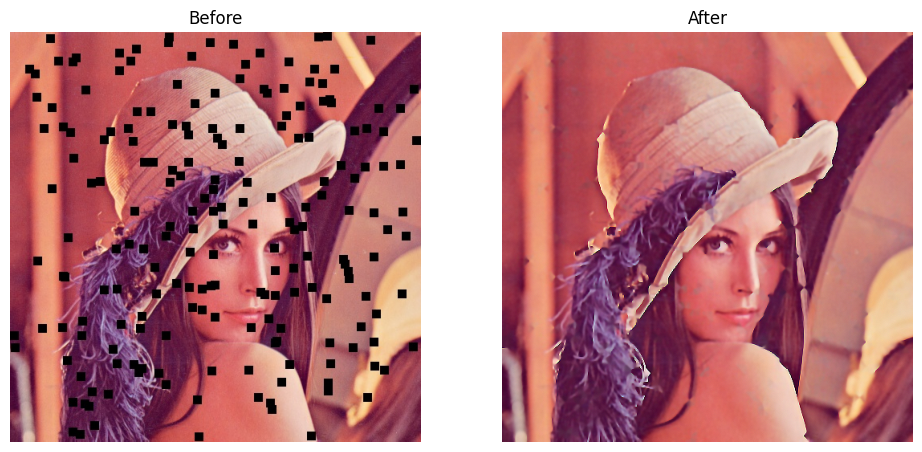

In [10]:
import cv2
import matplotlib.pyplot as plt

# Step 2: Read the image with holes
image_with_holes = cv2.imread(r"C:\Users\VIET HOANG - VTS\Desktop\testoutput\square_errors_color.jpg")

# Step 3: Convert the image from BGR to RGB
image_with_holes_rgb = cv2.cvtColor(image_with_holes, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(18, 6))
# Step 4: Display the 'Before' image
plt.subplot(1, 3, 1)
plt.title('Before')
plt.imshow(image_with_holes_rgb)
plt.axis('off')

# Assuming 'restored_image' is already processed and available
# Step 6: Convert the restored image from BGR to RGB (if necessary)
restored_image_rgb = cv2.cvtColor(restored_image, cv2.COLOR_BGR2RGB)
restored_image_rgb = anisotropic_diffusion(restored_image_rgb)
restored_image_rgb = sharpen_image(restored_image_rgb)
# Step 7: Display the 'After' image
cv2.imwrite(r'C:\Users\VIET HOANG - VTS\Desktop\testoutput\restored_img_txt.jpg', restored_image_rgb)
plt.subplot(1, 3, 2)
plt.title('After')
plt.imshow(restored_image_rgb)
plt.axis('off')

plt.show()


# Fixing scratches errors

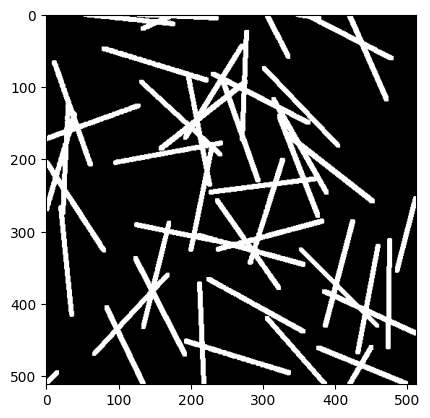

11.745746388443019
List L is not empty. Proceeding to the next steps.
11
(27, 28, 3)
(27, 28)
(589, 2)
10
(72, 53, 3)
(72, 53)
(2188, 2)
9
(124, 37, 3)
(124, 37)
(2451, 2)
8
(62, 145, 3)
(62, 145)
(5471, 2)
7
(33, 206, 3)
(33, 206)
(2825, 2)
6
(131, 155, 3)
(131, 155)
(6460, 2)
5
(156, 185, 3)
(156, 185)
(14201, 2)
4
(150, 166, 3)
(150, 166)
(6780, 2)
3
(205, 170, 3)
(205, 170)
(15157, 2)
2
(373, 141, 3)
(373, 141)
(21225, 2)
1
(498, 409, 3)
(498, 409)
(59059, 2)
done


In [12]:
# Main inpainting loop
damaged_image_multiple_rectangles = cv2.imread(r"C:\Users\VIET HOANG - VTS\Desktop\testoutput\color_scratched_image.jpg")
labeled_image, regions, binary_image = identify_missing_regions(damaged_image_multiple_rectangles)
plt.imshow(binary_image, cmap='gray')
plt.show()
# Sort regions by area in descending order and store them in a list tagged as L
L = sort_regions_by_area(regions)
print(percentile_area(L))
if not check_if_empty(L):
    # Select and dilate the smallest region
    while L:
        print(len(L))
        mask, dilated_mask = select_and_dilate_smallest_region(L, damaged_image_multiple_rectangles)
        # Turn white noise areas into black
        damaged_image_multiple_rectangles[mask == 255] = 0
        # Crop the corresponding area from the original image
        cropped_area, bbox = crop_corresponding_area(dilated_mask, damaged_image_multiple_rectangles)
        
        #cropped_area = anisotropic_diffusion(cropped_area)
        # Compute the smoothing parameter
        sigma, I_x, I_y = compute_smoothing_parameter(cropped_area)
        dilated_mask = dilated_mask_crop(cropped_area)
        # Create training data from the cropped area
        print(cropped_area.shape)
        print(dilated_mask.shape)
        X_train, y_train = create_training_data_from_cropped(cropped_area, dilated_mask)
        # Fit the GRNN model
        
        print(X_train.shape)

        grnn_model = OptimizedGRNN(sigma=sigma)
        grnn_model.fit(X_train, y_train.reshape(-1, y_train.shape[-1]))
        # Inpaint the damaged region
        
        inpainted_area = cropped_area.copy()
        damaged_coords = np.column_stack(np.where(dilated_mask))
        
        if damaged_coords.size > 0:
            predicted_values = grnn_model.predict(damaged_coords)
            if len(cropped_area.shape) == 3:
                inpainted_area[damaged_coords[:, 0], damaged_coords[:, 1], :] = predicted_values.astype(np.uint8)
            else:
                inpainted_area[damaged_coords[:, 0], damaged_coords[:, 1]] = predicted_values.astype(np.uint8).flatten()
        else:
            print("No damaged regions found")
            L.pop()
            continue
        
        # Restore the inpainted area back to the original image
        x, y, w, h = bbox
        restored_image = damaged_image_multiple_rectangles.copy()
        restored_image[y:y+h, x:x+w] = inpainted_area
        
        # Save the restored image
        cv2.imwrite(r'C:\Users\VIET HOANG - VTS\Desktop\testoutput\restored_img_txt.jpg', restored_image)

        # Sharpen the restored image
        sharpened_image = sharpen_image(restored_image)

        # Display the original, inpainted, and sharpened images
        # plt.figure(figsize=(18, 6))

        # plt.subplot(1, 3, 1)
        # plt.title('Before')
        # plt.imshow(damaged_image_multiple_rectangles, cmap='gray')
        # plt.axis('off')

        # plt.subplot(1, 3, 2)
        # plt.title('After')
        # plt.imshow(restored_image, cmap='gray')
        # plt.axis('off')
        damaged_image_multiple_rectangles = restored_image
        plt.show()
        if L:
            L.pop()
    print('done')
else:
    print("No missing regions found in the image.")

In [13]:
import cv2
import matplotlib.pyplot as plt

# Step 2: Read the image with holes
image_with_holes = cv2.imread(r"C:\Users\VIET HOANG - VTS\Desktop\testoutput\color_scratched_image.jpg")

# Step 3: Convert the image from BGR to RGB
image_with_holes_rgb = cv2.cvtColor(image_with_holes, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(18, 6))
# Step 4: Display the 'Before' image
plt.subplot(1, 3, 1)
plt.title('Before')
plt.imshow(image_with_holes_rgb)
plt.axis('off')

# Assuming 'restored_image' is already processed and available
# Step 6: Convert the restored image from BGR to RGB (if necessary)
restored_image_rgb = anisotropic_diffusion(restored_image_rgb)
restored_image_rgb = sharpen_image(restored_image_rgb)
cv2.imwrite(r'C:\Users\VIET HOANG - VTS\Desktop\testoutput\restored_color_scratch.jpg', restored_image)
restored_image_rgb = cv2.cvtColor(restored_image, cv2.COLOR_BGR2RGB)

# Step 7: Display the 'After' image
plt.subplot(1, 3, 2)
plt.title('After')
plt.imshow(restored_image_rgb)
plt.axis('off')

plt.show()


## For noise masking

In [14]:
import numpy as np
import cv2
from skimage import measure
import matplotlib.pyplot as plt

def identify_noise_regions(noisy_image):
    # Load the original and noisy images
    image_path = r"C:\Users\VIET HOANG - VTS\Desktop\testdata\Lenna_color.png"
    original_image = cv2.imread(image_path)
    #original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    # Calculate the noise component
    noise_component = cv2.subtract(noisy_image, original_image)
    noise_level = np.mean(np.abs(noise_component))

    # Threshold the noise component to identify significant deviations (noise)
    _, binary_image = cv2.threshold(noise_component, 30, 255, cv2.THRESH_BINARY)
    
    # Label the binary image
    labeled_image = measure.label(binary_image, connectivity=2)
    regions = measure.regionprops(labeled_image)
    
    return labeled_image, regions, binary_image

noisy_img = cv2.imread(r"C:\Users\VIET HOANG - VTS\Desktop\testoutput\color_salt_pepper.jpg")
labeled_image, regions, binary_image = identify_noise_regions(noisy_img)
plt.imshow(binary_image, cmap='gray')
plt.show()



# Experiment on noisy images

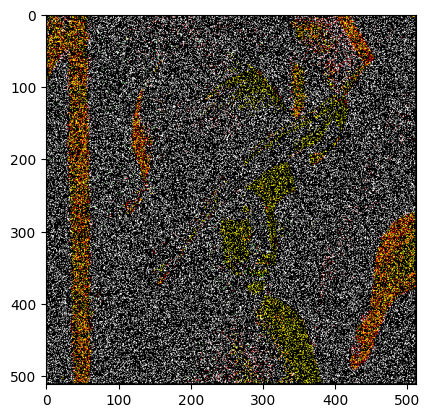

45.20500802568218
List L is not empty. Proceeding to the next steps.
15758
(16, 19, 3)
(16, 19)
(217, 2)
15757
(16, 19, 3)
(16, 19)
(236, 2)
15756
(19, 19, 3)
(19, 19)
(235, 2)
15755
(19, 19, 3)
(19, 19)
(271, 2)
15754
(19, 19, 3)
(19, 19)
(325, 2)
15753
(19, 19, 3)
(19, 19)
(282, 2)
15752
(19, 19, 3)
(19, 19)
(264, 2)
15751
(19, 19, 3)
(19, 19)
(343, 2)
15750
(19, 19, 3)
(19, 19)
(236, 2)
15749
(19, 19, 3)
(19, 19)
(287, 2)
15748
(19, 19, 3)
(19, 19)
(253, 2)
15747
(19, 19, 3)
(19, 19)
(246, 2)
15746
(19, 19, 3)
(19, 19)
(274, 2)
15745
(19, 19, 3)
(19, 19)
(229, 2)
15744
(19, 19, 3)
(19, 19)
(242, 2)
15743
(19, 19, 3)
(19, 19)
(229, 2)
15742
(19, 19, 3)
(19, 19)
(269, 2)
15741
(19, 19, 3)
(19, 19)
(225, 2)
15740
(19, 19, 3)
(19, 19)
(265, 2)
15739
(19, 19, 3)
(19, 19)
(231, 2)
15738
(19, 19, 3)
(19, 19)
(239, 2)
15737
(19, 19, 3)
(19, 19)
(234, 2)
15736
(19, 19, 3)
(19, 19)
(262, 2)
15735
(19, 19, 3)
(19, 19)
(222, 2)
15734
(19, 19, 3)
(19, 19)
(229, 2)
15733
(19, 19, 3)
(19, 19)
(330

In [15]:
# Main inpainting loop
damaged_image_multiple_rectangles = cv2.imread(r'C:\Users\VIET HOANG - VTS\Desktop\testoutput\color_salt_pepper.jpg')
labeled_image, regions, binary_image = identify_noise_regions(damaged_image_multiple_rectangles)
plt.imshow(binary_image, cmap='gray')
plt.show()
# Sort regions by area in descending order and store them in a list tagged as L
L = sort_regions_by_area(regions)
print(percentile_area(L))
if not check_if_empty(L):
    # Select and dilate the smallest region
    while L:
        print(len(L))
        mask, dilated_mask = select_and_dilate_smallest_region(L, damaged_image_multiple_rectangles)
        # Turn white noise areas into black
        damaged_image_multiple_rectangles[mask == 255] = 0
        # Crop the corresponding area from the original image
        cropped_area, bbox = crop_corresponding_area(dilated_mask, damaged_image_multiple_rectangles)
        
        #cropped_area = anisotropic_diffusion(cropped_area)
        # Compute the smoothing parameter
        sigma, I_x, I_y = compute_smoothing_parameter(cropped_area)
        dilated_mask = dilated_mask_crop(cropped_area)
        # Create training data from the cropped area
        print(cropped_area.shape)
        print(dilated_mask.shape)
        X_train, y_train = create_training_data_from_cropped(cropped_area, dilated_mask)
        # Fit the GRNN model
        
        print(X_train.shape)

        grnn_model = OptimizedGRNN(sigma=sigma)
        grnn_model.fit(X_train, y_train.reshape(-1, y_train.shape[-1]))
        # Inpaint the damaged region
        
        inpainted_area = cropped_area.copy()
        damaged_coords = np.column_stack(np.where(dilated_mask))
        
        if damaged_coords.size > 0:
            predicted_values = grnn_model.predict(damaged_coords)
            if len(cropped_area.shape) == 3:
                inpainted_area[damaged_coords[:, 0], damaged_coords[:, 1], :] = predicted_values.astype(np.uint8)
            else:
                inpainted_area[damaged_coords[:, 0], damaged_coords[:, 1]] = predicted_values.astype(np.uint8).flatten()
        else:
            print("No damaged regions found")
            L.pop()
            continue
        
        # Restore the inpainted area back to the original image
        x, y, w, h = bbox
        restored_image = damaged_image_multiple_rectangles.copy()
        restored_image[y:y+h, x:x+w] = inpainted_area
        
        # Save the restored image
        cv2.imwrite(r'C:\Users\VIET HOANG - VTS\Desktop\testoutput\restored_img_txt.jpg', restored_image)

        # Sharpen the restored image
        sharpened_image = sharpen_image(restored_image)

        # Display the original, inpainted, and sharpened images
        # plt.figure(figsize=(18, 6))

        # plt.subplot(1, 3, 1)
        # plt.title('Before')
        # plt.imshow(damaged_image_multiple_rectangles, cmap='gray')
        # plt.axis('off')

        # plt.subplot(1, 3, 2)
        # plt.title('After')
        # plt.imshow(restored_image, cmap='gray')
        # plt.axis('off')
        damaged_image_multiple_rectangles = restored_image
        plt.show()
        if L:
            L.pop()
            
    print('done')
else:
    print("No missing regions found in the image.")

# Run an extra loop to see if the result getting better

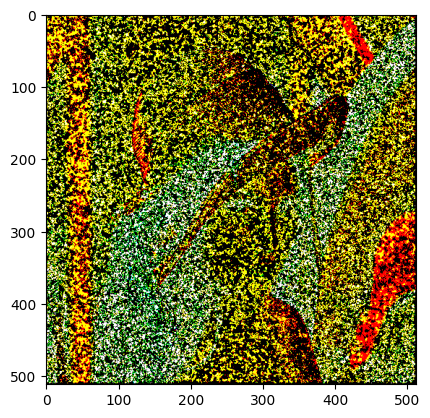

59.283980738362764
List L is not empty. Proceeding to the next steps.
2197
(10, 19, 3)
(10, 19)
(189, 2)
2196
(10, 19, 3)
(10, 19)
(189, 2)
2195
(12, 19, 3)
(12, 19)
(227, 2)
2194
(12, 19, 3)
(12, 19)
(227, 2)
2193
(13, 19, 3)
(13, 19)
(246, 2)
2192
(14, 19, 3)
(14, 19)
(265, 2)
2191
(14, 19, 3)
(14, 19)
(265, 2)
2190
(15, 19, 3)
(15, 19)
(284, 2)
2189
(15, 19, 3)
(15, 19)
(284, 2)
2188
(15, 19, 3)
(15, 19)
(284, 2)
2187
(16, 19, 3)
(16, 19)
(303, 2)
2186
(16, 19, 3)
(16, 19)
(303, 2)
2185
(17, 19, 3)
(17, 19)
(322, 2)
2184
(17, 19, 3)
(17, 19)
(322, 2)
2183
(18, 19, 3)
(18, 19)
(341, 2)
2182
(18, 19, 3)
(18, 19)
(341, 2)
2181
(19, 19, 3)
(19, 19)
(360, 2)
2180
(19, 19, 3)
(19, 19)
(360, 2)
2179
(19, 19, 3)
(19, 19)
(360, 2)
2178
(19, 19, 3)
(19, 19)
(360, 2)
2177
(19, 19, 3)
(19, 19)
(360, 2)
2176
(19, 19, 3)
(19, 19)
(360, 2)
2175
(19, 19, 3)
(19, 19)
(360, 2)
2174
(19, 19, 3)
(19, 19)
(360, 2)
2173
(19, 19, 3)
(19, 19)
(360, 2)
2172
(19, 19, 3)
(19, 19)
(359, 2)
2171
(19, 19, 3)
(19

In [16]:
# Main inpainting loop
damaged_image_multiple_rectangles = cv2.imread(r'C:\Users\VIET HOANG - VTS\Desktop\testoutput\restored_img_txt.jpg')
labeled_image, regions, binary_image = identify_noise_regions(damaged_image_multiple_rectangles)
plt.imshow(binary_image, cmap='gray')
plt.show()
# Sort regions by area in descending order and store them in a list tagged as L
L = sort_regions_by_area(regions)
print(percentile_area(L))
if not check_if_empty(L):
    # Select and dilate the smallest region
    while L:
        print(len(L))
        mask, dilated_mask = select_and_dilate_smallest_region(L, damaged_image_multiple_rectangles)
        # Turn white noise areas into black
        damaged_image_multiple_rectangles[mask == 255] = 0
        # Crop the corresponding area from the original image
        cropped_area, bbox = crop_corresponding_area(dilated_mask, damaged_image_multiple_rectangles)
        
        #cropped_area = anisotropic_diffusion(cropped_area)
        # Compute the smoothing parameter
        sigma, I_x, I_y = compute_smoothing_parameter(cropped_area)
        dilated_mask = dilated_mask_crop(cropped_area)
        # Create training data from the cropped area
        print(cropped_area.shape)
        print(dilated_mask.shape)
        X_train, y_train = create_training_data_from_cropped(cropped_area, dilated_mask)
        # Fit the GRNN model
        
        print(X_train.shape)

        grnn_model = OptimizedGRNN(sigma=sigma)
        grnn_model.fit(X_train, y_train.reshape(-1, y_train.shape[-1]))
        # Inpaint the damaged region
        
        inpainted_area = cropped_area.copy()
        damaged_coords = np.column_stack(np.where(dilated_mask))
        
        if damaged_coords.size > 0:
            predicted_values = grnn_model.predict(damaged_coords)
            if len(cropped_area.shape) == 3:
                inpainted_area[damaged_coords[:, 0], damaged_coords[:, 1], :] = predicted_values.astype(np.uint8)
            else:
                inpainted_area[damaged_coords[:, 0], damaged_coords[:, 1]] = predicted_values.astype(np.uint8).flatten()
        else:
            print("No damaged regions found")
            L.pop()
            continue
        
        # Restore the inpainted area back to the original image
        x, y, w, h = bbox
        restored_image = damaged_image_multiple_rectangles.copy()
        restored_image[y:y+h, x:x+w] = inpainted_area
        
        # Save the restored image
        cv2.imwrite(r'C:\Users\VIET HOANG - VTS\Desktop\testoutput\restored_img_txt.jpg', restored_image)

        # Sharpen the restored image
        sharpened_image = sharpen_image(restored_image)

        # Display the original, inpainted, and sharpened images
        # plt.figure(figsize=(18, 6))

        # plt.subplot(1, 3, 1)
        # plt.title('Before')
        # plt.imshow(damaged_image_multiple_rectangles, cmap='gray')
        # plt.axis('off')

        # plt.subplot(1, 3, 2)
        # plt.title('After')
        # plt.imshow(restored_image, cmap='gray')
        # plt.axis('off')
        damaged_image_multiple_rectangles = restored_image
        plt.show()
        if L:
            L.pop()
            
    print('done')
else:
    print("No missing regions found in the image.")

In [19]:
import cv2
import matplotlib.pyplot as plt

# Step 2: Read the image with holes
image_with_holes = cv2.imread(r'C:\Users\VIET HOANG - VTS\Desktop\testoutput\color_salt_pepper.jpg')

# Step 3: Convert the image from BGR to RGB
image_with_holes_rgb = cv2.cvtColor(image_with_holes, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(18, 6))
# Step 4: Display the 'Before' image
plt.subplot(1, 3, 1)
plt.title('Before')
plt.imshow(image_with_holes_rgb)
plt.axis('off')

# Assuming 'restored_image' is already processed and available
# Step 6: Convert the restored image from BGR to RGB (if necessary)
restored_image_rgb = anisotropic_diffusion(restored_image_rgb)
restored_image_rgb = sharpen_image(restored_image_rgb)
cv2.imwrite(r'C:\Users\VIET HOANG - VTS\Desktop\testoutput\restored_img_txt.jpg', restored_image)
restored_image_rgb = cv2.cvtColor(restored_image, cv2.COLOR_BGR2RGB)

# Step 7: Display the 'After' image
plt.subplot(1, 3, 2)
plt.title('After')
plt.imshow(restored_image_rgb)
plt.axis('off')

plt.show()


In [20]:
# Main inpainting loop
damaged_image_multiple_rectangles = cv2.imread(r'C:\Users\VIET HOANG - VTS\Desktop\testoutput\restored_img_txt.jpg')
labeled_image, regions, binary_image = identify_noise_regions(damaged_image_multiple_rectangles)
plt.imshow(binary_image, cmap='gray')
plt.show()
# Sort regions by area in descending order and store them in a list tagged as L
L = sort_regions_by_area(regions)
print(percentile_area(L))
if not check_if_empty(L):
    # Select and dilate the smallest region
    while L:
        print(len(L))
        mask, dilated_mask = select_and_dilate_smallest_region(L, damaged_image_multiple_rectangles)
        # Turn white noise areas into black
        damaged_image_multiple_rectangles[mask == 255] = 0
        # Crop the corresponding area from the original image
        cropped_area, bbox = crop_corresponding_area(dilated_mask, damaged_image_multiple_rectangles)
        
        #cropped_area = anisotropic_diffusion(cropped_area)
        # Compute the smoothing parameter
        sigma, I_x, I_y = compute_smoothing_parameter(cropped_area)
        dilated_mask = dilated_mask_crop(cropped_area)
        # Create training data from the cropped area
        print(cropped_area.shape)
        print(dilated_mask.shape)
        X_train, y_train = create_training_data_from_cropped(cropped_area, dilated_mask)
        # Fit the GRNN model
        
        print(X_train.shape)

        grnn_model = OptimizedGRNN(sigma=sigma)
        grnn_model.fit(X_train, y_train.reshape(-1, y_train.shape[-1]))
        # Inpaint the damaged region
        
        inpainted_area = cropped_area.copy()
        damaged_coords = np.column_stack(np.where(dilated_mask))
        
        if damaged_coords.size > 0:
            predicted_values = grnn_model.predict(damaged_coords)
            if len(cropped_area.shape) == 3:
                inpainted_area[damaged_coords[:, 0], damaged_coords[:, 1], :] = predicted_values.astype(np.uint8)
            else:
                inpainted_area[damaged_coords[:, 0], damaged_coords[:, 1]] = predicted_values.astype(np.uint8).flatten()
        else:
            print("No damaged regions found")
            L.pop()
            continue
        
        # Restore the inpainted area back to the original image
        x, y, w, h = bbox
        restored_image = damaged_image_multiple_rectangles.copy()
        restored_image[y:y+h, x:x+w] = inpainted_area
        
        # Save the restored image
        cv2.imwrite(r'C:\Users\VIET HOANG - VTS\Desktop\testoutput\restored_img_txt.jpg', restored_image)

        # Sharpen the restored image
        sharpened_image = sharpen_image(restored_image)

        # Display the original, inpainted, and sharpened images
        # plt.figure(figsize=(18, 6))

        # plt.subplot(1, 3, 1)
        # plt.title('Before')
        # plt.imshow(damaged_image_multiple_rectangles, cmap='gray')
        # plt.axis('off')

        # plt.subplot(1, 3, 2)
        # plt.title('After')
        # plt.imshow(restored_image, cmap='gray')
        # plt.axis('off')
        damaged_image_multiple_rectangles = restored_image
        plt.show()
        if L:
            L.pop()
            
    print('done')
else:
    print("No missing regions found in the image.")

3.1458105939004817
List L is not empty. Proceeding to the next steps.
5172
(10, 19, 3)
(10, 19)
(189, 2)
5171
(11, 19, 3)
(11, 19)
(208, 2)
5170
(11, 19, 3)
(11, 19)
(208, 2)
5169
(11, 19, 3)
(11, 19)
(208, 2)
5168
(11, 19, 3)
(11, 19)
(208, 2)
5167
(11, 19, 3)
(11, 19)
(208, 2)
5166
(11, 19, 3)
(11, 19)
(208, 2)
5165
(12, 19, 3)
(12, 19)
(227, 2)
5164
(12, 19, 3)
(12, 19)
(227, 2)
5163
(12, 19, 3)
(12, 19)
(227, 2)
5162
(12, 19, 3)
(12, 19)
(227, 2)
5161
(12, 19, 3)
(12, 19)
(227, 2)
5160
(12, 19, 3)
(12, 19)
(227, 2)
5159
(12, 19, 3)
(12, 19)
(227, 2)
5158
(12, 19, 3)
(12, 19)
(227, 2)
5157
(13, 19, 3)
(13, 19)
(246, 2)
5156
(13, 19, 3)
(13, 19)
(246, 2)
5155
(13, 19, 3)
(13, 19)
(246, 2)
5154
(13, 19, 3)
(13, 19)
(246, 2)
5153
(14, 19, 3)
(14, 19)
(265, 2)
5152
(14, 19, 3)
(14, 19)
(265, 2)
5151
(14, 19, 3)
(14, 19)
(265, 2)
5150
(14, 19, 3)
(14, 19)
(265, 2)
5149
(14, 19, 3)
(14, 19)
(265, 2)
5148
(14, 19, 3)
(14, 19)
(265, 2)
5147
(14, 19, 3)
(14, 19)
(265, 2)
5146
(15, 19, 3)
(15